In [1]:
pip install --quiet pip pillow tqdm opencv-python imutils scikit-image

Note: you may need to restart the kernel to use updated packages.


## 3 - cut images using unet masks

In [2]:
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import cv2
import imutils
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# opencv masks
#folder_target = Path("RESULT_single_dices_opencv")
#folder_masks = Path("RESULT_dice-mfa-blue-good/train/masks")
#folder_masks = Path("/data/dice-CHEAT/RESULT_dice-mfa-blue-good/train/masks")
# unet masks
folder_target = Path("RESULT_single_dices_unet")
#folder_masks = Path("RESULT_dice-mfa-blue-unet-masks")
folder_masks = Path("/data/dice-CHEAT/RESULT_dice-mfa-blue-unet-masks")
#
folder_images = Path("/data/dice-mfa-blue-good")

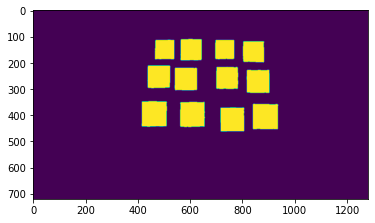

In [4]:
image_name = "G020022_720p.png"
mask_img = Image.open(f"{folder_masks}/{image_name}")
plt.imshow(mask_img)
plt.show()

In [5]:
img_np = np.array(mask_img)

In [6]:
img_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

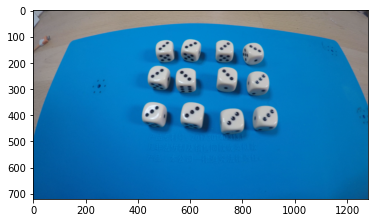

In [7]:
img = cv2.imread(f"{folder_images}/train/{image_name}")
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [8]:
cnts = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

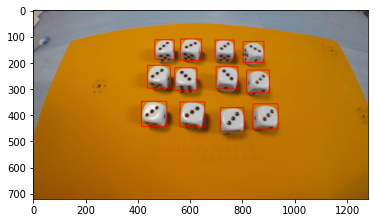

In [9]:
c_median = np.median([len(i) for i in cnts if len(i) > 2])
cut_imgs = []
img_rect = img.copy()
for c in cnts:
    if len(c) < 0.5 * c_median or len(c) > 1.5 * c_median:
        continue
    if len(c) < 3:
        continue
    x1 = min([i[0][0] for i in c])
    x2 = max([i[0][0] for i in c])
    y1 = min([i[0][1] for i in c])
    y2 = max([i[0][1] for i in c])
    is_rectangle = ((x2-x1) / (y2-y1))
    if is_rectangle < 0.7 or is_rectangle > 1.3:
        continue
    mw_x, mw_y = (x2+x1)/2, (y1+y2)/2
    quad_len = max(x2-x1, y2-y1)
    cut_imgs.append(
        img[int(mw_y-quad_len/2):int(mw_y+quad_len/2), int(mw_x-quad_len/2):int(mw_x+quad_len/2)])
    cv2.rectangle(img_rect, (int(mw_x-quad_len/2), int(mw_y-quad_len/2)),
                  (int(mw_x+quad_len/2), int(mw_y+quad_len/2)), (255, 0, 0), 2)
plt.imshow(img_rect)
plt.show()

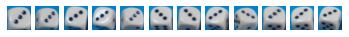

In [10]:
for idx, i in enumerate(cut_imgs):
    plt.subplot(1, 12, idx + 1)
    i = np.flip(i, axis=2)  # fix colors
    plt.imshow(i)
    plt.axis("off")
plt.show()

In [11]:
filename_map = {
    "G01": "6",
    "G02": "3",
    "G04": "5",
    "G05": "1",
    "G06": "2",
    "G07": "4",
}

In [12]:
# save the dices as images
base_fn = image_name.split("_")[0]
base_folder = Path(folder_target)
[(base_folder / str(i)).mkdir(parents=True, exist_ok=True) for i in range(1, 7)]
for idx, i in enumerate(cut_imgs):
    fn = base_folder / filename_map[base_fn[:3]] / f"{base_fn}_{idx:02d}.png"
    i = np.flip(i, axis=2)  # fix colors
    _img = Image.fromarray(i.astype('uint8'), 'RGB')
    _img.save(fn, output="png")

now for all the images

In [13]:
[(folder_target / str(i)).mkdir(parents=True, exist_ok=True) for i in range(1, 7)]
files = list(folder_masks.glob("*png"))

for mask_fn in tqdm(files, total=len(files)):
    base_fn = mask_fn.name.split("_")[0]
    mask_img = Image.open(mask_fn)
    
    img_np = np.array(mask_img)
    cnts = cv2.findContours(img_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c_median = np.median([len(i) for i in cnts if len(i) > 2])

    img = cv2.imread(f"{folder_images}/train/{mask_fn.name}")
    for (idx, c) in enumerate(cnts):
        if len(c) < 0.5 * c_median or len(c) > 1.5 * c_median:
            continue
        if len(c) < 3:
            continue
        x1 = min([i[0][0] for i in c])
        x2 = max([i[0][0] for i in c])
        y1 = min([i[0][1] for i in c])
        y2 = max([i[0][1] for i in c])
        is_rectangle = ((x2-x1) / (y2-y1))
        if is_rectangle < 0.7 or is_rectangle > 1.3:
            continue
        mw_x, mw_y = (x2+x1)/2, (y1+y2)/2
        quad_len = max(x2-x1, y2-y1)
        dice_img = img[int(mw_y-quad_len/2):int(mw_y+quad_len/2),
                       int(mw_x-quad_len/2):int(mw_x+quad_len/2)]
        if dice_img.shape[0] == 0 or dice_img.shape[1] == 0:
            print(f"remove {mask_fn.name} please")
            continue
        
        dice_img = np.flip(dice_img, axis=2)  # fix colors
        _img = Image.fromarray(dice_img.astype('uint8'), 'RGB')
        
        fn = folder_target / filename_map[base_fn[:3]] / f"{base_fn}_{idx:02d}.png"
        _img.save(fn, output="png")

  0%|          | 0/836 [00:00<?, ?it/s]

remove G050181_720p.png please


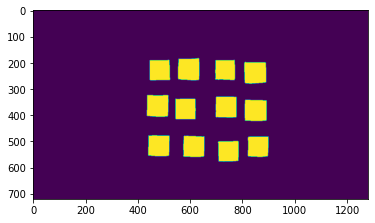

In [14]:
# this was to debug the crashes when x==0 or y==0
img = Image.open(mask_fn)
plt.imshow(img)
plt.show()

In [15]:
len(list(folder_target.glob("*/*png")))

9317

In [16]:
len(list(Path("RESULT_single_dices_opencv").glob("*/*png")))

9931

In [17]:
len(list(Path("RESULT_single_dices_unet").glob("*/*png")))

9317